In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from itertools import zip_longest
from sklearn.neighbors import KernelDensity
from statsmodels.tsa.api import SimpleExpSmoothing
from textwrap import wrap
from scipy import stats

# Calculating Forecast Errors

We have multiple demand signals that serve the purpose of demand forecast. In this analysis we will be using JD as our forecast signal. We will be looking at errors on this forecast signal across all the products we plan for. While calculating the forecast error, we will collect the following metrics. 

nomenclature:
<br>

$lag\_x\_forecast$: the quantity forecasted for the week x weeks ago  
$A_t$: Actual Orders placed at time t  
$F_t$: Forecast for time t  
$deviation_t = F_t - A_t$  
$abs\_deviation_t = |deviation_t|$  
$ap\_error = {\frac{abs\_deviation_t}{A_t}}$  
$p\_error = {\frac{\_deviation_t}{A_t}}$  
$p\_error\_f = {\frac{\_deviation_t}{F_t}}$  
$sap\_error = {\frac{F_t}{F_t + A_t}}$  
$cum\_F_t = \sum_{i=1}^t F_i$  
$cum\_A_t = \sum_{i=1}^t A_i$  
$cum\_deviation_t = cum\_F_t - cum\_A_t$  
$abs\_cum\_deviation_t = |cum\_deviation_t|$  
$cum\_ap\_error = {\frac{abs\_deviation_t}{cum\_A_t}}$  
$cum\_sap\_error = {\frac{cum\_F_t}{cum\_F_t + cum\_A_t}}$  


**ap_error (Absolute Percentage Error)**: The absolute percentage error metric helps us see how different the absolute difference between actual orders placed and forecasted demand are with respect to the actual orders placed per time. This metric will have the inherent problem of having huge quantities when the error made in forecast is quite a few orders of magnitude times that of the actuals.

**sap_error (Scaled Mean Absolute Percentage Error)**: The scaled absolute percentage error metric helps us see the error made in forecast within the range of 0 to 1, since the metric uses division by sum of forecast and actuals. The way to interpret this error metric is that if the number is 0.5 we forecasted accurately, if it was greater than 0.5, we overcalled our forecast, ie. forecast is more than actuals, and if it was less than 0.5 we undercalled our forecast.

**cum_ap_error (Cumulative Absolute Percentage Error)**: Orders will not be placed every week, hence there will be zeros in those weeks for orders, while at the same time demand might be forecasted for those weeks. Inorder to handle this situation, it is best to calculate error in terms of the cumulative horizon as expressed in the equation above.

**cum_sap_error (Cumulative Absolute Percentage Error)**: Similar to the rationale above, we would benefit with a metric that captures the cumulative error for this normalized error metric, whose equation is shared above.

# Forecast errors vs. work week
Analyzing the weighted mean of forecast error in each work week (across all product families)

In [2]:
# Functions
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))



def create_weights(vals, weight_type):
    if weight_type == 'right skewed':
        weights = [np.sqrt(x) for x in range(1, len(vals)+1)]
    elif weight_type == 'symmetric':
        x_list = []
        # Number of values is even
        if len(vals) % 2 == 0:
            for i in range(0, int(len(vals)/2)):
                x_list.append(i)
                x_list.append(-1*i)
        # Number of values is odd
        else:
            x_list.append(0)
            for i in range(1, int((len(vals)-1)/2)+1):
                x_list.append(i)
                x_list.append(-1*i)
        x_list.sort()
        weights = [2*gaussian(x, mu = 0, sig = 2) for x in x_list]
    elif weight_type == 'none':
        weights = [1]*len(vals)
    
    return weights
        
        

def weighted_mean(vals, weight_type, non_zero, print_cond):
    # Initialize the sums (numerator and denominator for mean)
    vals_sum = 0
    weights_sum = 0
    
    # Use non-zero and/or non-NaN values only for mean
    if non_zero == 'True':
        vals = [val for val in vals if ((val != 0) & np.isfinite(val))]
    else:
        vals = [val for val in vals if np.isfinite(val)]
        
    # Compute weights after finalizing the list of values to use
    weights = create_weights(vals, weight_type)
    
    # Check if the number of values and weights are the same, if not, terminate computation
    if len(weights) != len(vals):
        print('Number of values and weights is unequal; terminating weighted mean computation')
        return
    
    # Compute the sums (numerator and denominator for mean)
    for i in range(0, len(vals)):
        if print_cond == 'True':
            print('Error value is not NaN or infinity')
        vals_sum = vals_sum + (vals[i]*weights[i])
        weights_sum = weights_sum + weights[i]       
    if weights_sum != 0:
        wm = vals_sum/weights_sum
    else:
        wm = np.nan
    
    return wm



def date_sum(date, incr):
    date = int(date)
    incr = int(incr)
    sum_naive = date + incr
    if int(str(sum_naive)[4:6]) > 52:
        diff = str(abs(52 - int(str(sum_naive)[4:6])))
        if len(diff) == 1:
            diff = '0'+diff
        sum_true = str(int(str(date)[0:4])+1)+diff
    else: 
        sum_true = sum_naive
    return int(sum_true)



def list_transpose(list_of_lists):
    lens = []
    for list_entry in list_of_lists:
        lens.append(len(list_entry))

    trans_list_of_lists = []
    for i in range(0,max(lens)):
        new_list = []
        for list_entry in list_of_lists:
            try:
                new_list.append(list_entry[i])
            except:
                continue
        trans_list_of_lists.append(new_list)
    return trans_list_of_lists



def create_periods(num_vals, period_len, period_name):
    num_periods = np.round(num_vals/period_len)
    period_list = []
    for i in range(0, int(num_periods)+1):
        if period_name == 'words':
            period = 'period_'+str(i)
            period_list.extend([period]*period_len)
        elif period_name == 'numbers':
            period = str(i)
            period_list.extend([period]*period_len)
    period_list = period_list[0:num_vals]
    return period_list


def create_single_period(num_vals, period_start_index, period_len, period_name):
    period_list = [0]*num_vals
    if period_name == 'words':
        period_list[period_start_index:period_start_index+period_len] = ['period_present']*period_len
    elif period_name == 'numbers':
        period_list[period_start_index:period_start_index+period_len] = [1]*period_len
    return period_list



In [3]:
# Pandas view
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 15)

In [4]:
# HCF demand or JD
forecast_vs_order_df = pd.read_pickle('./forecast_hcf_vs_order_df.pkl')  
forecast_vs_order_df = pd.concat([pd.read_pickle('./forecast_jd_vs_order_df_part1.pkl'), pd.read_pickle('./forecast_jd_vs_order_df_part2.pkl')])

In [5]:
# Creating dataframe with forecast data only
forecasts_df = forecast_vs_order_df[['group_name', 'work_week', 'ssbi_load_ww', 'actual_order', 'forecast']]
forecasts_df = forecasts_df.rename(columns={'group_name': 'product_group', 'work_week': 'forecast_for_ww', 
                                'ssbi_load_ww': 'forecast_made_ww'})
forecasts_df.reset_index(drop = True, inplace = True)

In [6]:
# Removing unecessary data: same dates for forecast and actual orders, zero values for forecast
forecasts_df = forecasts_df[(forecasts_df['forecast_made_ww'] != forecasts_df['forecast_for_ww']) & (forecasts_df['forecast'] != 0) & 
                            (forecasts_df['actual_order'] != 0)]
forecasts_df.reset_index(drop = True, inplace = True)

In [51]:
# Dimensionality reduction #1: reducing all forecasts for a given ww to a single value using weighted mean: 
#       prod_a: [forecast_ww1, forecast_ww2, ....], 
#       prod_b: [forecast_ww1, forecast_ww2, ....], and so on
# Result is a df where for every product, every week of its PLC has a single forecast and actual associated with it

product_ww_group_df = forecasts_df.groupby(['product_group', 'forecast_for_ww'])
forecasts_df_red = pd.DataFrame()

products_list = []
forecasts_list = []
actuals_list = []
ww_list = []

for product_group in forecasts_df['product_group'].unique():
    for ww in forecasts_df[forecasts_df['product_group'] == product_group]['forecast_for_ww'].sort_values().unique():
        df = product_ww_group_df.get_group((product_group, ww)).sort_values(by = 'forecast_made_ww')
        products_list.append(product_group)
        forecasts_list.append(weighted_mean(vals = list(df['forecast']), weight_type = 'right skewed', 
                                            non_zero = 'True', print_cond = 'False'))
        #forecasts_list.append(np.mean(df['forecast']))
        actuals_list.append(np.max(df['actual_order']))
        ww_list.append(ww)
        
forecasts_df_red['product_group'] = products_list
forecasts_df_red['forecast'] = forecasts_list
forecasts_df_red['actual_order'] = actuals_list
forecasts_df_red['forecast_for_ww'] = ww_list

In [ ]:
# Checking if demand follows a normal distribution
p_values = []
for product_group in forecasts_df_red['product_group'].unique():
    forecasts_df_red[forecasts_df_red['product_group'] == product_group]['actual_order'].hist(bins = 100)
    try:
        shapiro_test = stats.shapiro(list(forecasts_df_red[forecasts_df_red['product_group'] == product_group]['actual_order']))
        p_values.append(shapiro_test.pvalue)
    except:
        continue
    plt.show()

In [170]:
# Calculate average p-value from Shapiro Wilk test for normality
p_values.sort()
np.mean(p_values[0:-15])

0.0011497738501009718

In [8]:
# Creating a static set of periods (data wastage)
forecasts_df_red = forecasts_df_red.sort_values(by = ['product_group', 'forecast_for_ww'])
forecasts_df_red.reset_index(drop = True, inplace = True)
all_products_periods = []
for product_group in forecasts_df_red['product_group'].unique():
    num_vals = len(forecasts_df_red[(forecasts_df_red['product_group'] == product_group)])
    all_products_periods.extend(create_periods(num_vals, period_len = 3, period_name = 'words'))
forecasts_df_red['periods'] = all_products_periods

In [9]:
# Errors for static set of periods (data wastage)
all_products_periods_error = []
for product_group in forecasts_df_red['product_group'].unique():
    product_periods_error = []
    for period in forecasts_df_red[(forecasts_df_red['product_group'] == product_group)]['periods'].unique():
        product_df = forecasts_df_red[(forecasts_df_red['product_group'] == product_group) & (forecasts_df_red['periods'] == period)]
        product_periods_error.append(((product_df['forecast'].sum() - product_df['actual_order'].sum())/product_df['actual_order'].sum())*100)
    all_products_periods_error.append(product_periods_error)

In [ ]:
# Errors for dynamic set of periods (less data wastage)
all_products_periods_error = []
period_len = 3
for product_group in forecasts_df_red['product_group'].unique():
    product_df = forecasts_df_red[(forecasts_df_red['product_group'] == product_group)]
    if ((len(product_df) > 100)):
        product_periods_error = []
        for i in range(0,len(product_df)-period_len):
            product_df.loc[:,'periods'] = create_single_period(num_vals = len(product_df), period_start_index = i, 
                                                               period_len = period_len, period_name = 'numbers')
            period_df = product_df[product_df['periods'] == 1]
            product_periods_error.append(((period_df['forecast'].sum() - period_df['actual_order'].sum())/period_df['actual_order'].sum())*100)
        all_products_periods_error.append(product_periods_error)

In [210]:
# RMSE of all products and periods
def flatten(l):
    return [item for sublist in l for item in sublist]

rmse = np.sqrt(((np.array(flatten(all_products_periods_error))) ** 2).mean())
me = np.array(flatten(all_products_periods_error)).mean()

Text(0, 0.5, 'forecast errors for each SSD program')

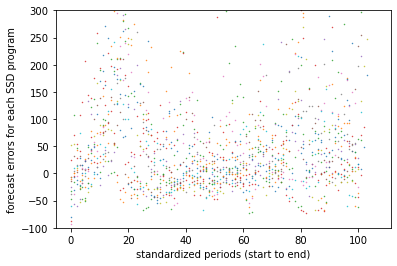

In [200]:
# Superimposing all product errors per ww
for product_periods_error in all_products_periods_error:
    # Display errors per product
    plt.scatter(x = range(0, len(product_periods_error)), y = product_periods_error, s = 0.2)
plt.ylim([-100, 300])
plt.xlabel('standardized periods (start to end)')
plt.ylabel('forecast errors for each SSD program')

In [96]:
# Restructuring of result from dimensionality reduction #1:
#       [[err_ww1_prod_a, err_ww1_prod_b, err_ww1_prod_c, ......],
#        [err_ww2_prod_a, err_ww2_prod_b, err_ww2_prod_c, ......],
#        ....]
# Result is an error vector for each ww

len_list = []
for product_periods_error in all_products_periods_error:
    len_list.append(len(product_periods_error))

all_periods_error = []
for i in range(0,max(len_list)):
    error_list = []
    for product_periods_error in all_products_periods_error:
        try:
            error_list.append(product_periods_error[i])
        except:
            continue
    all_periods_error.append(error_list)

Error for standardized period 0 is:  -8.935573336112947
Error for standardized period 1 is:  16.274908603509875
Error for standardized period 2 is:  9.983490080245296
Error for standardized period 3 is:  22.73052203065218
Error for standardized period 4 is:  16.12507969808751
Error for standardized period 5 is:  26.821980569756953
Error for standardized period 6 is:  51.4957348370832
Error for standardized period 7 is:  54.64856408349549
Error for standardized period 8 is:  109.15443334815275
Error for standardized period 9 is:  107.72427975161337
Error for standardized period 10 is:  112.94410006193566
Error for standardized period 11 is:  122.87094185923185
Error for standardized period 12 is:  164.92932480944978
Error for standardized period 13 is:  241.82861159465637
Error for standardized period 14 is:  200.49268232719976
Error for standardized period 15 is:  205.27764500374548
Error for standardized period 16 is:  234.02103468392096
Error for standardized period 17 is:  208.96490

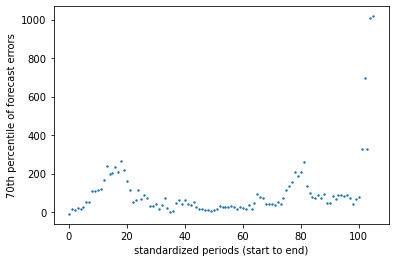

In [98]:
# Dimensionality reduction #2: reduce errors per ww to a single value using using percentiles
#     ww_1: x percentile of [err_ww1_prod_a, err_ww1_prod_b, err_ww1_prod_c, ......],
#     ww_2: x percentile of [err_ww2_prod_a, err_ww2_prod_b, err_ww2_prod_c, ......], and so on

standardized_period = 0
error_list = []
for period_error_list in all_periods_error:
    inp = np.array(period_error_list)[~np.isnan(period_error_list)]
    if len(inp) != 0:
        error_list.append(np.percentile(inp, 70))
        print('70th percentile of error for standardized period', standardized_period, 'is: ', np.percentile(inp, 70))
        standardized_period = standardized_period + 1
        
# Printing error per work week
plt.scatter(range(0,len(error_list)), error_list, s = 2)
plt.xlabel('standardized periods (start to end)')
plt.ylabel('70th percentile of forecast errors')
plt.ylim([-100, 300])
plt.show()

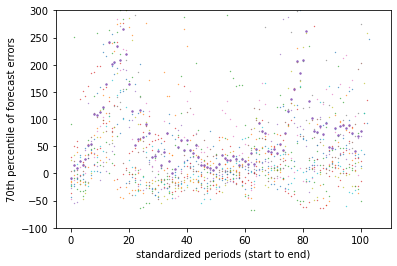

In [99]:
# Superimposing all product errors per ww
for product_periods_error in all_products_periods_error:
    # Display errors per product
    plt.scatter(x = range(0, len(product_periods_error)), y = product_periods_error, s = 0.1)
# Percentile error for all product groups per ww
plt.scatter(range(0,len(error_list)), error_list, s = 2)
plt.xlabel('standardized periods (start to end)')
plt.ylabel('70th percentile of forecast errors')
plt.ylim([-100, 300])
plt.show()

In [ ]:
# Dimensionality reduction #2: reduce errors per ww to a single value using using kernel density estimation
#     ww_1: max probability of [err_ww1_prod_a, err_ww1_prod_b, err_ww1_prod_c, ......],
#     ww_2: max probability of [err_ww2_prod_a, err_ww2_prod_b, err_ww2_prod_c, ......], and so on

standardized_period = 0
error_list = []
for period_error_list in all_periods_error:
    inp = np.array(period_error_list)[~np.isnan(period_error_list)].reshape(-1, 1)
    period_error_list_red = []
    if len(inp) >= 4:
        kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(inp)
        kde_scores = list(np.exp(kde.score_samples(inp)))
        print('Most likely error for standardized period', standardized_period, 'is:', inp[kde_scores.index(max(kde_scores))][0])
        period_error_list_red.append(inp[kde_scores.index(max(kde_scores))][0])
        kde_scores.remove(max(kde_scores))
        print('Second most likely error for standardized period', standardized_period, 'is:', inp[kde_scores.index(max(kde_scores))][0])
        period_error_list_red.append(inp[kde_scores.index(max(kde_scores))][0])
        kde_scores.remove(max(kde_scores))
        print('Third most likely error for standardized period', standardized_period, 'is:', inp[kde_scores.index(max(kde_scores))][0])
        period_error_list_red.append(inp[kde_scores.index(max(kde_scores))][0])
    standardized_period = standardized_period + 1
    error_list.append(period_error_list_red)

# Visualising error per period
i = 0
for perior_error_list_red in error_list:
    plt.scatter([i]*len(perior_error_list_red), perior_error_list_red, s = 2)
    i = i + 1
plt.xlabel('standardized period (start to end)')
plt.ylabel('forecast error with 1st, 2nd and 3rd highest probabilities (kde)')
plt.show()

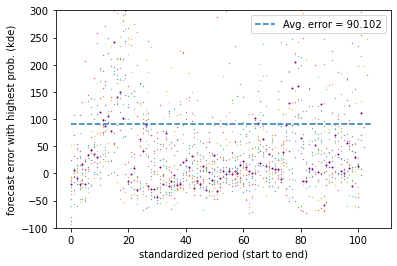

In [214]:
# Superimposing all product errors per ww
for product_periods_error in all_products_periods_error:
    # Display errors per product
    plt.scatter(x = range(0, len(product_periods_error)), y = product_periods_error, s = 0.1)
# kde error for all product groups per ww
i = 0
for perior_error_list_red in error_list:
    plt.scatter([i]*len(perior_error_list_red), perior_error_list_red, s = 1, c = 'purple')
    i = i + 1
plt.xlabel('standardized period (start to end)')
plt.ylabel('forecast error with highest prob. (kde)')
plt.hlines(y = me, xmin = 0, xmax = 105, linestyles='--', label = 'Avg. error = 90.102')

plt.legend(loc = "upper right")
plt.ylim([-100, 300])
plt.show()

In [157]:
# Example of kde on a single period (all products)
for ww in range(0,100):
    matrix_for_ww = [error_list[ww-1], error_list[ww], error_list[ww+1]]
    print('work week is:', ww, 'error matrix is:', matrix_for_ww)

work week is: 0 error matrix is: [[], [-18.684999867278957, -16.50538112603398, -18.684999867278957], [6.443119721808246, 6.738883513524874, -11.334467914706172]]
work week is: 1 error matrix is: [[-18.684999867278957, -16.50538112603398, -18.684999867278957], [6.443119721808246, 6.738883513524874, -11.334467914706172], [-8.441583033516382, 17.98427152317881, -7.332442149903202]]
work week is: 2 error matrix is: [[6.443119721808246, 6.738883513524874, -11.334467914706172], [-8.441583033516382, 17.98427152317881, -7.332442149903202], [-20.046771666868526, -2.7347536277198974, 12.132117527862203]]
work week is: 3 error matrix is: [[-8.441583033516382, 17.98427152317881, -7.332442149903202], [-20.046771666868526, -2.7347536277198974, 12.132117527862203], [16.82312775604961, 16.82312775604961, 16.05231651486121]]
work week is: 4 error matrix is: [[-20.046771666868526, -2.7347536277198974, 12.132117527862203], [16.82312775604961, 16.82312775604961, 16.05231651486121], [-19.910467724293245, 

In [124]:
fit = SimpleExpSmoothing(error_list, initialization_method="estimated").fit()
fcast_list = []
for i in range(2,len(error_list)):
    fit = SimpleExpSmoothing(error_list[0:i], initialization_method="estimated").fit()
    fcast = fit.forecast(1)
    fcast_list.append(fcast[0])

(-100.0, 300.0)

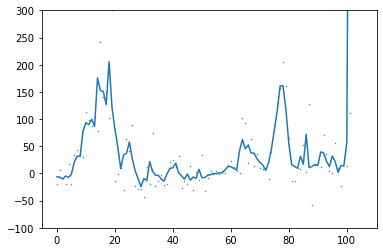

In [125]:
plt.plot(fcast_list)
plt.scatter(x = range(0, len(error_list)), y = error_list, s = 0.2)
plt.ylim([-100, 300])

In [ ]:
# Testing model on a new program
product_group = 'CLIFFDALE REFRESH 1TB 2.5 PCIE SE SSD'


# Actuals (A_t)
actual_orders = []
for ww in forecasts_df[forecasts_df['product_group'] == product_group]['forecast_for_ww'].sort_values().unique():
    actual_orders.append(forecasts_df[(forecasts_df['product_group'] == product_group) & (forecasts_df['forecast_for_ww'] == ww)]['actual_order'].unique()[0])

# Demand forecast (F_t)
product_ww_group_df = forecasts_df.groupby(['product_group', 'forecast_for_ww'])
demand_forecast = []
for ww in forecasts_df[forecasts_df['product_group'] == product_group]['forecast_for_ww'].sort_values().unique():
    df = product_ww_group_df.get_group((product_group, ww)).sort_values(by = 'forecast_made_ww')
    vals = list(df['forecast'])
    demand_forecast.append(weighted_mean(vals, weight_type = 'right skewed', non_zero = 'True', print_cond = 'False'))

# Predicting actuals using the error vector (Pred_A_t = F_t - error_vec*F_t)
predicted_actuals = [x - y for x, y in zip(demand_forecast, [demand_forecast[i]*error_list[i] for i in range(len(demand_forecast))])]


In [ ]:
plt.scatter(x = range(0,len(predicted_actuals)), y = predicted_actuals, s = 2)
plt.scatter(x = range(0, len(actual_orders)), y = actual_orders, s = 2)
plt.scatter(x = range(0, len(demand_forecast)), y = demand_forecast, s = 2)

plt.legend(['Predicted demand', 'True demand', 'Weighted mean of demand forecast'])
plt.xlabel('standardized weeks (start to end)')
plt.ylabel('actual demand')